In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance

In [12]:
df = pd.read_csv('/Users/Devyani/msads/ml2/finalproj/mlp_files/compas_sample_200.csv')

In [14]:
df.head()

,arrest_charge_degree,person_id,is_recid,juv_fel_count,juv_misd_count,juv_other_count,prison_in,prison_out,prison_duration_days,legal_status,marital_status,race,sex,age,priors_count,c_charge_degree,filing_type,filing_agency,initial_charge,initial_statute
0,(F3),2723,1,0,0,0,2013-08-29 12:29:01.000000,2015-03-20 12:11:27.000000,567.987801,Pretrial,Single,African-American,Male,25,4,(F3),No Information,Sunrise PD,Attempt Crim Use of Personal ID Info,817.568(2)(a)
1,(M1),6448,1,0,0,0,2014-11-05 03:30:09.000000,2014-11-06 03:30:00.000000,0.999896,Pretrial,Single,Caucasian,Male,29,4,(M1),SAO Information,Miramar PD,Resist/Obstruct W/O Violence,843.02
2,(M1),4725,1,1,0,0,2013-12-11 12:58:30.000000,2014-01-21 09:54:00.000000,40.871875,Pretrial,Single,African-American,Female,51,10,(F3),No Information,Broward Sheriff Office/Pompano Beach,Resist/obstruct Officer W/viol,843.01
3,(0),7302,1,1,1,0,2015-04-28 09:23:02.000000,2015-12-07 09:43:55.000000,223.014502,Pretrial,Single,African-American,Male,41,24,(F3),SAO Information,Broward Sheriff Office/Oakland Park,Leaving The Scene Of Accident,327.035
4,(M2),2382,1,0,0,0,2014-01-21 12:50:29.000000,2014-03-11 05:40:00.000000,48.701053,Pretrial,Married,African-American,Male,58,24,(F3),No Information,Broward Sheriff Office/Pompano Beach,Possession Burglary Tools,810.06


In [33]:
df.shape

(200, 19)

In [16]:
df['prison_in'] = pd.to_datetime(df['prison_in'], errors='coerce')
df['prison_out'] = pd.to_datetime(df['prison_out'], errors='coerce')
df['prison_in_year'] = df['prison_in'].dt.year
df['prison_out_year'] = df['prison_out'].dt.year
#timestamps cannot be read into mlp, extracting year for numerical variable instead

In [18]:
df = df.drop(columns=['person_id', 'prison_in', 'prison_out'])

In [20]:
#dropping person_id -- can lead to overfitting
#dropping prison_in and prison_out as they are timestamp fields and cannot be included in mlp

In [22]:
y = df['is_recid']
X = df.drop(columns=['is_recid'])
#dropping target variable

In [24]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [28]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42))
])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'prison_duration_days',
                                                   'age', 'priors_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['arrest_charge_degree',
                                                   'legal_status',
                                                   'marital_status', 'race',
                                                   'sex', 'c_charge_degree',
                                                   'filing_type',
                                                   'filing_agency',
                                                   'initial_charge',
                                                   'initial_statute'])])),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(50,), max_iter=500,
                               random_state=42))])

In [40]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.20      0.14         5
           1       0.87      0.77      0.82        35

    accuracy                           0.70        40
   macro avg       0.49      0.49      0.48        40
weighted avg       0.78      0.70      0.73        40



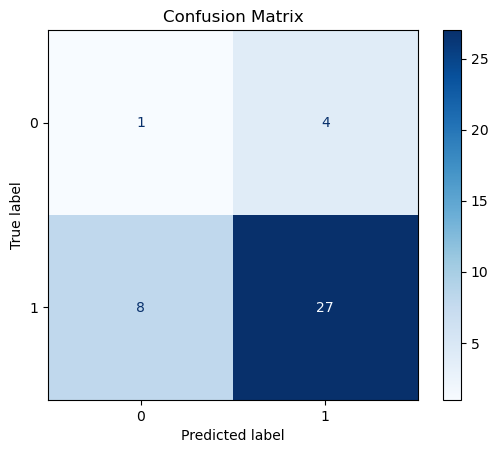

In [48]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [55]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feature_names = (
    numeric_features +
    list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
)

In [57]:
ohe = clf.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

In [61]:
min_len = min(len(feature_names), len(result.importances_mean))

importances_df = pd.DataFrame({
    'feature': feature_names[:min_len],
    'importance': result.importances_mean[:min_len]
}).sort_values(by='importance', ascending=False)

In [63]:
print("\nTop 10 Important Features:")
print(importances_df.head(10))


Top 10 Important Features:
                      feature  importance
9   arrest_charge_degree_(F3)      0.0425
4                         age      0.0300
10  arrest_charge_degree_(F7)      0.0225
1              juv_misd_count      0.0175
11  arrest_charge_degree_(M1)      0.0100
2             juv_other_count      0.0050
16    marital_status_Divorced      0.0000
17     marital_status_Married      0.0000
5                priors_count      0.0000
3        prison_duration_days     -0.0050
